# Recap on the data

The following dataset was obtained from kaggle.com ([dataset link](https://www.kaggle.com/uciml/mushroom-classification)). According to kaggle, this dataset was donated to donated to UCI Machine Learning  in 27 April 1987, which makes this data set almost 30 years old. 

This set consists of **23** features of mushrooms from **Agaricus and Lepiota Family**. 

All data is categorical with some missing values (particularly in the 'stalk-root' column). 

Alltogether, there are **8124** mushrooms classified

## Table Legend
According to UCL ML, the table data is coded as follows:

* Class: edible =e,poisonous=p 
* Cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s 
* Cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s 
* Cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y 
* Bruises?: bruises=t,no=f 
* Odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s 
* Gill-attachment: attached=a,descending=d,free=f,notched=n 
* Gill-spacing: close=c,crowded=w,distant=d 
* Gill-size: broad=b,narrow=n 
* Gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y 
* Stalk-shape: enlarging=e,tapering=t 
* Stalk-root: bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=? 
* Stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s 
* Stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s 
* Stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y 
* Stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y 
* Veil-type: partial=p,universal=u 
* Veil-color: brown=n,orange=o,white=w,yellow=y 
* Ring-number: none=n,one=o,two=t 
* Ring-type: cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z 
* Spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y 
* Population: abundant=a,clustered=c,numerous=n, scattered=s,several=v,solitary=y 
* Habitat: grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d


## Conclusions from previous project
* Most mushrooms without smell are edible
* Most mushrooms with smell are poisonous
* Contrary to the intuitive, the mushrooms in wastelands don't stink
* The biggest proportion of smelly/non-smelly mushrooms can be found in paths, which means that mushrooms in paths stink
* There can be found color differences between poisonous and edible mushrooms with regards to rgb coordinates, the difference is too small or definite to have an actual practical value

Future notes:
* Use different regrouping tactic to differenciate between mushroom colors 
* Look into whole mushroom color schema

## Problems with kaggle kernels:
* Label encoding and then scaling???????????????????????



## Current project aims to:
* to some degree, properly handle the data
* find important features
* find at least some meaningfull insights with arbitrary feature engineering
* make some reusable functions that i can use later in life


In [466]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [467]:
# this was usefull when working in azure
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.22.1.


In [475]:
#importing everything i need
import pandas as pd
import numpy as np
import itertools
from sklearn import metrics
import math


import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import jaccard_similarity_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score


print('setup complete')

setup complete


In [0]:
#important dunctions

#the following functions are taken from fastai library
def rf_feat_importance(m, df):
  return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

def display_all(df):
  with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): display(df)

def interactions(data, features):
  interact = pd.DataFrame(index=data.index)
  for col1, col2 in itertools.combinations(features, 2):
    new_col_name = '_'.join([col1, col2])
    new_values = data[col1].map(str) + "_" + data[col2].map(str)
    interact[new_col_name] = new_values
  return interact


# spliting when you want to have train, validations and test set as well
def spliting_data(X, y):
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
   X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
   return X_train, X_val, y_train, y_val, X_test, y_test 

#this function is made to be reused when working both with random forests and linear models - do_cats_only = True is required for linear models before scaling
def apply_codes(df, cat_cols = None, do_cats_only = True):
  if cat_cols is None:
    df = df.astype('category')   
    df = df.cat.codes
  else:
    df[cat_cols] = df[cat_cols].apply(lambda x: x.astype('category'))
    if do_cats_only is not True:
      df[cat_cols] = df[cat_cols].apply(lambda x: x.cat.codes)
  return df


#this is a pipeline function that makes a transformer for your need, just input your categorical and/or numerical column names
def pipeline(num_feat = None, cat_feat = None):
  if num_feat is None:
    if cat_feat is None:
      print('ummmm pls input at least some columns')
    else:
      categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                                ('onehot', OneHotEncoder(handle_unknown='ignore'))])
      preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, cat_feat)])
      return preprocessor
  else:
    if cat_feat is None:
      numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                            ('scaler', StandardScaler())])
      preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_feat)])
      return preprocessor
    else:
      numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                            ('scaler', StandardScaler())])
      categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                                ('onehot', OneHotEncoder(handle_unknown='ignore'))])
      preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_feat),
                                                     ('cat', categorical_transformer, cat_feat)])
      return preprocessor


# Short Data Analysis

In [494]:
full_data = pd.read_csv('/content/drive/My Drive/projectML/mushrooms.csv')
full_data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [495]:
full_data.shape

(8124, 23)

In [496]:
display_all(full_data.describe())

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [497]:
full_data.isnull().any().sum()

0

# Lets Get Right to the model
* lets chose random forrest baseline model and see how it does
*for convenient purposes lets not do one hot encoding right now, random forests can handle that


In [0]:
# X and y
y = full_data['class']
X = full_data.drop(columns = 'class')

In [507]:
X.shape, y.shape

((8124, 22), (8124,))

In [0]:
# cat column recoding
X = apply_codes(X, cat_cols = list(X.columns.values), do_cats_only = False)
y = apply_codes(y)

In [528]:
X.dtypes

cap-shape                   int8
cap-surface                 int8
cap-color                   int8
bruises                     int8
odor                        int8
gill-attachment             int8
gill-spacing                int8
gill-size                   int8
gill-color                  int8
stalk-shape                 int8
stalk-root                  int8
stalk-surface-above-ring    int8
stalk-surface-below-ring    int8
stalk-color-above-ring      int8
stalk-color-below-ring      int8
veil-type                   int8
veil-color                  int8
ring-number                 int8
ring-type                   int8
spore-print-color           int8
population                  int8
habitat                     int8
dtype: object

In [529]:
# train test split
X_train, X_val, y_train, y_val, _, _ = spliting_data(X, y)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((5199, 22), (1300, 22), (5199,), (1300,))

In [0]:
baseline_forest = RandomForestClassifier()
baseline_forest.fit(X_train,y_train)
# predictions
baseline_forest_predict = baseline_forest.predict(X_val)

# We have a baseline forrest now! lets evaluate

In [0]:
#ill use just the training data for folds
scores = cross_val_score(baseline_forest, X_train, y_train, cv= 10,scoring='roc_auc')

In [532]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val, baseline_forest_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_val, baseline_forest_predict))
print('\n')
print("=== All AUC Scores ===")
print(scores)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", scores.mean())

=== Confusion Matrix ===
[[676   0]
 [  0 624]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       676
           1       1.00      1.00      1.00       624

    accuracy                           1.00      1300
   macro avg       1.00      1.00      1.00      1300
weighted avg       1.00      1.00      1.00      1300



=== All AUC Scores ===
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  1.0


## what

# did i make a mitsake

# whats the feature importance??

In [533]:
fi = rf_feat_importance(baseline_forest, X_train); 
fi[:5]

,cols,imp
4,odor,0.151089
8,gill-color,0.135835
7,gill-size,0.120953
19,spore-print-color,0.098744
18,ring-type,0.076716


# ok, lets use first 2-5th features, im sure it cant predict 100 %, right?????

In [0]:
features1 = columns = fi[2:5].cols.values.tolist()

In [540]:
features1

['gill-size', 'spore-print-color', 'ring-type']

In [544]:
# X and y
y = full_data['class']
X = full_data[features1]
# cat column recoding
X = apply_codes(X, cat_cols = list(X.columns.values), do_cats_only = False)
y = apply_codes(y)
# train test split
X_train, X_val, y_train, y_val, _, _ = spliting_data(X, y)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


((5199, 3), (1300, 3), (5199,), (1300,))

In [0]:
baseline_forest = RandomForestClassifier()
baseline_forest.fit(X_train,y_train)
# predictions
baseline_forest_predict = baseline_forest.predict(X_val)

#lets evaluate these features

In [546]:
#ill use just the training data for folds
scores = cross_val_score(baseline_forest, X_train, y_train, cv= 10,scoring='roc_auc')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val, baseline_forest_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_val, baseline_forest_predict))
print('\n')
print("=== All AUC Scores ===")
print(scores)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", scores.mean())

=== Confusion Matrix ===
[[649  27]
 [  0 624]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       676
           1       0.96      1.00      0.98       624

    accuracy                           0.98      1300
   macro avg       0.98      0.98      0.98      1300
weighted avg       0.98      0.98      0.98      1300



=== All AUC Scores ===
[1.   1.   1.   0.99 0.99 0.99 0.99 1.   0.99 0.99]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9942309237439897


# there is something fishy here
i ran these experiments over and over with different features. cross validation fits here, as this is only a baseline model that does not have its hyperparameters tuned. the score got worse only when i took the least important features from my model, and even then, the precision and recall was the same, which basically means that the model can predict both categories the same. 
* i care more about high precision more here - its more important to predict that some mushrooms are poisonous when they are not rather than predict that poisonous mushrooms are not poisonous
* i did the same experiments with interaction variables and it got the same result
* kaggle kernels, that did everything ok(did not scale categorical features), found the same results
 

# Clustering and feature engineering

* i wanted to engineer some features and see how they perform when predicting mushroom eadability. This was done in order to extrapolate something useful from this data
* i took all color features and recoded them into arbitrary rgb values. 

In [547]:
colors = [i for i in full_data.columns if 'color' in i]
full_data[colors].describe()

,cap-color,gill-color,stalk-color-above-ring,stalk-color-below-ring,veil-color,spore-print-color
count,8124,8124,8124,8124,8124,8124
unique,10,12,9,9,4,9
top,n,b,w,w,w,w
freq,2284,1728,4464,4384,7924,2388


* bellow is a simple vizualization of some categorical color features of edible and poisonous mushrooms, i took the code from my last project

gill-color,b,e,g,h,k,n,o,p,r,u,w,y
class,,,,,,,,,,,,
e,0,96,248,204,344,936,64,852,0,444,956,64
p,1728,0,504,528,64,112,0,640,24,48,246,22


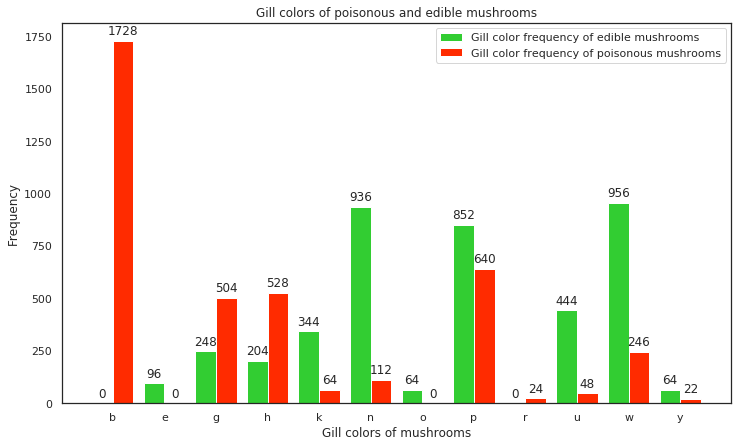

In [549]:
#gill_colorX edible
gill_class = pd.crosstab(full_data['class'], full_data['gill-color'])
edible = gill_class.iloc[0]
poisonous = gill_class.iloc[1]
figure, ax = plt.subplots(figsize = (12, 7))

width = 0.4
label_loc = np.arange(12)
bars_edible = ax.bar(label_loc-width/2, edible, width, label = 'Gill color frequency of edible mushrooms', color ='#32CD32' )
bars_poisonous = ax.bar(label_loc + width/2, poisonous, width, label = 'Gill color frequency of poisonous mushrooms', color = '#FF2B00')
ax.legend()
ax.set_xlabel('Gill colors of mushrooms')
ax.set_ylabel('Frequency')
ax.set_title('Gill colors of poisonous and edible mushrooms')
ax.set_xticklabels(list(gill_class.columns))
ax.set_xticks(label_loc) 

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(bars_edible)
autolabel(bars_poisonous)
gill_class

spore-print-color,b,h,k,n,o,r,u,w,y
class,,,,,,,,,
e,48,48,1648,1744,48,0,48,576,48
p,0,1584,224,224,0,72,0,1812,0


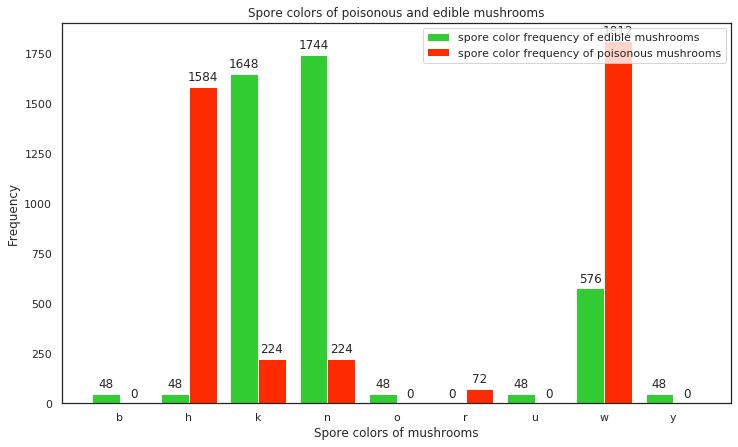

In [550]:
#gill_colorX edible
spore_class = pd.crosstab(full_data['class'], full_data['spore-print-color'])
edible = spore_class.iloc[0]
poisonous = spore_class.iloc[1]
figure, ax = plt.subplots(figsize = (12, 7))

width = 0.4
label_loc = np.arange(9)
bars_edible = ax.bar(label_loc-width/2, edible, width, label = 'spore color frequency of edible mushrooms', color ='#32CD32' )
bars_poisonous = ax.bar(label_loc + width/2, poisonous, width, label = 'spore color frequency of poisonous mushrooms', color = '#FF2B00')
ax.legend()
ax.set_xlabel('Spore colors of mushrooms')
ax.set_ylabel('Frequency')
ax.set_title('Spore colors of poisonous and edible mushrooms')
ax.set_xticklabels(list(spore_class.columns))
ax.set_xticks(label_loc) 

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(bars_edible)
autolabel(bars_poisonous)
spore_class

In [0]:
data_colors = full_data[colors]

In [552]:
data_colors.describe()

,cap-color,gill-color,stalk-color-above-ring,stalk-color-below-ring,veil-color,spore-print-color
count,8124,8124,8124,8124,8124,8124
unique,10,12,9,9,4,9
top,n,b,w,w,w,w
freq,2284,1728,4464,4384,7924,2388


In [0]:
def map_colors(df, feats):
  color_keys = {'k': 'Black',
                'n': 'Brown',
                'b': 'Buff',
                'h': 'Chocolate',
                'g': 'Gray',
                'r': 'Green',
                'o': 'Orange',
                'p': 'Pink',
                'u': 'Purple',
                'e': 'Red', 
                'w': 'White',
                'y': 'Yellow', 
                'c': 'Cinammon'}
  color_grouping_rgb =  {'Black': [0, 0, 0],
                         'Brown': [165, 42, 42],
                         'Buff': [240, 220, 130],
                         'Chocolate': [123, 63, 0],
                         'Gray': [128, 128, 128],
                         'Green': [112, 220, 112],
                         'Orange': [255, 140, 0],
                         'Pink': [255, 129, 203],
                         'Purple': [48, 25, 52],
                         'Red': [192, 0, 0],
                         'White': [255, 255, 255],
                         'Yellow': [255,255,102],
                         'Cinammon': [210, 105, 30]}

  for feat in feats:
    df[feat] = df[feat].map(color_keys)
    df[feat] = df[feat].map(color_grouping_rgb)
  return df

def split_values_into_cols(df, feats, col_pre):
  for feat in feats:
    rgb_rank = df[feat].apply(pd.Series)
    col_names = [feat+pre for pre in col_pre]
    rgb_rank.columns = col_names 
    df = pd.concat([df, rgb_rank], axis=1, sort=False)
  df.drop(feats, axis = 1, inplace = True)
  return df

In [553]:
mapped_colors = map_colors(data_colors, colors)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [557]:
mapped_colors

,cap-color,gill-color,stalk-color-above-ring,stalk-color-below-ring,veil-color,spore-print-color
0,"[165, 42, 42]","[0, 0, 0]","[255, 255, 255]","[255, 255, 255]","[255, 255, 255]","[0, 0, 0]"
1,"[255, 255, 102]","[0, 0, 0]","[255, 255, 255]","[255, 255, 255]","[255, 255, 255]","[165, 42, 42]"
2,"[255, 255, 255]","[165, 42, 42]","[255, 255, 255]","[255, 255, 255]","[255, 255, 255]","[165, 42, 42]"
3,"[255, 255, 255]","[165, 42, 42]","[255, 255, 255]","[255, 255, 255]","[255, 255, 255]","[0, 0, 0]"
4,"[128, 128, 128]","[0, 0, 0]","[255, 255, 255]","[255, 255, 255]","[255, 255, 255]","[165, 42, 42]"
...,...,...,...,...,...,...
8119,"[165, 42, 42]","[255, 255, 102]","[255, 140, 0]","[255, 140, 0]","[255, 140, 0]","[240, 220, 130]"
8120,"[165, 42, 42]","[255, 255, 102]","[255, 140, 0]","[255, 140, 0]","[165, 42, 42]","[240, 220, 130]"
8121,"[165, 42, 42]","[165, 42, 42]","[255, 140, 0]","[255, 140, 0]","[255, 140, 0]","[240, 220, 130]"
8122,"[165, 42, 42]","[240, 220, 130]","[255, 255, 255]","[255, 255, 255]","[255, 255, 255]","[255, 255, 255]"


In [0]:
rgb_values = split_values_into_cols(mapped_colors, colors, ['-red', '-green', '-blue'])

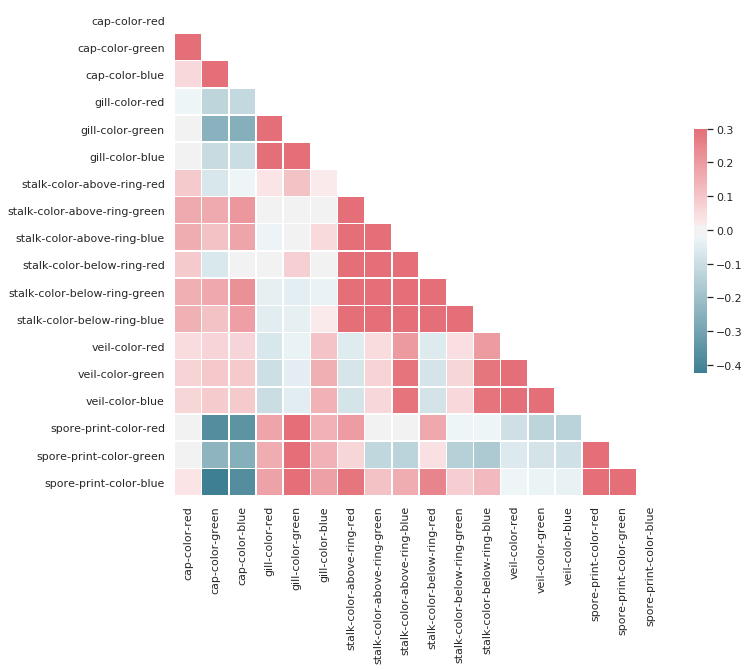

In [556]:
sns.set(style="white")
corr = rgb_values.corr(method = 'spearman')
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

* hmmmm, seems like there is some colinearity, but not that much. for simplicity purposes ill leave it like that, but for future maybe i'll do something with them 
* i used KNN clustering, to find whether the features that i have created form into somewhat meaningfull clusters 

In [0]:
X_cluster = rgb_values[['cap-color-red', 'cap-color-green', 'cap-color-blue']]

In [0]:
preprocessor1 = pipeline(num_feat = list(X_cluster.columns.values))

In [0]:
X_cluster = preprocessor1.fit_transform(X_cluster)

In [0]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_cluster)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [474]:
inertias

[24372.0,
 7938.261957676737,
 3165.6806766045893,
 1176.974239735886,
 471.27798267940614,
 201.57937187199116,
 125.09755956825276,
 68.11967678494837,
 16.76815289708926]

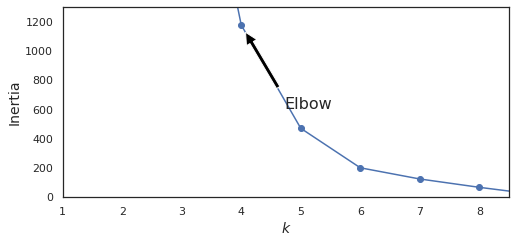

In [463]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

In [464]:
full_data['cap-color'].nunique()

10

* there seems that 4 cluster is the best number of clusters. in this category, cap color, there is 10 unique values, so there should be 10 clusters maybe?
* but after thinking for some time i cheched the discriptions of the categories - some of the taxonomical colors are very similar by their values (eg, cinammon and brown), so this clustering might be more accurate than these categories, at least for cap color

## lets try logistic regression with these color features 

In [0]:
y = apply_codes(full_data['class'])

In [0]:
X_train, X_val, y_train, y_val, _, _ = spliting_data(rgb_values, y)

In [562]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((5199, 18), (1300, 18), (5199,), (1300,))

In [563]:
X_train.dtypes

cap-color-red                   int64
cap-color-green                 int64
cap-color-blue                  int64
gill-color-red                  int64
gill-color-green                int64
gill-color-blue                 int64
stalk-color-above-ring-red      int64
stalk-color-above-ring-green    int64
stalk-color-above-ring-blue     int64
stalk-color-below-ring-red      int64
stalk-color-below-ring-green    int64
stalk-color-below-ring-blue     int64
veil-color-red                  int64
veil-color-green                int64
veil-color-blue                 int64
spore-print-color-red           int64
spore-print-color-green         int64
spore-print-color-blue          int64
dtype: object

In [0]:
preprocessor1 = pipeline(num_feat = list(rgb_values.columns.values))

In [0]:
X_train = preprocessor1.fit_transform(X_train)
X_val = preprocessor1.transform(X_val)

In [566]:
X_train.shape

(5199, 18)

In [567]:
y_train

7794    1
6836    1
4985    1
7167    0
2985    0
       ..
4095    0
5276    1
374     0
4344    1
6493    1
Length: 5199, dtype: int8

In [568]:
baseline_logistic = LogisticRegression()
baseline_logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_hat = baseline_logistic.predict(X_val)
yhat_prob = baseline_logistic.predict_proba(X_val)

In [570]:
jaccard_similarity_score(y_val, y_hat)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0.9146153846153846

In [455]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    "
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_val, y_hat, labels=[0,1]))

[[651  25]
 [ 86 538]]


Confusion matrix, without normalization
[[538  86]
 [ 25 651]]


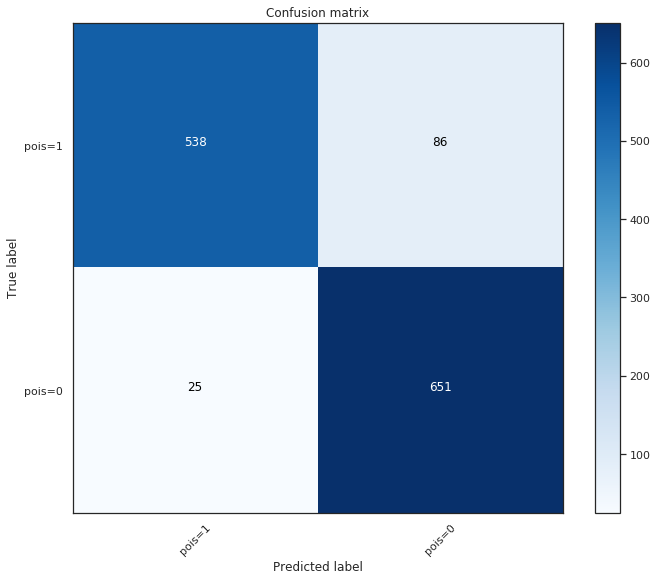

In [571]:
cnf_matrix = confusion_matrix(y_val, y_hat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['pois=1','pois=0'],normalize= False,  title='Confusion matrix')

In [572]:
# high precision, not so high recall is better
print (classification_report(y_val, y_hat))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       676
           1       0.96      0.86      0.91       624

    accuracy                           0.91      1300
   macro avg       0.92      0.91      0.91      1300
weighted avg       0.92      0.91      0.91      1300

